Импортируем библиотеки

In [52]:
import pandas as pd
import numpy as np
from google.colab import drive
import zipfile
import dask.dataframe as dd
import matplotlib.pyplot as plt
import polars as pl
import seaborn as sns
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Считываем файлы

In [53]:
df_train = pl.scan_csv('/content/drive/MyDrive/Colab Notebooks/мифи семестры/1 семестр/Python для анализа данных/1 дз/train.csv')
df_lectures = pl.scan_csv('/content/drive/MyDrive/Colab Notebooks/мифи семестры/1 семестр/Python для анализа данных/1 дз/lectures.csv')
df_questions = pl.scan_csv('/content/drive/MyDrive/Colab Notebooks/мифи семестры/1 семестр/Python для анализа данных/1 дз/questions.csv')

Посмотрим на типы данных и выведем первые записи

In [54]:
print("Типы данных\n", df_train.collect_schema())
print("Первые 5 записей\n", df_train.head(5).collect())

Типы данных
 Schema([('row_id', Int64), ('timestamp', Int64), ('user_id', Int64), ('content_id', Int64), ('content_type_id', Int64), ('task_container_id', Int64), ('user_answer', Int64), ('answered_correctly', Int64), ('prior_question_elapsed_time', Float64), ('prior_question_had_explanation', Boolean)])
Первые 5 записей
 shape: (5, 10)
┌────────┬───────────┬─────────┬────────────┬───┬────────────┬────────────┬────────────┬───────────┐
│ row_id ┆ timestamp ┆ user_id ┆ content_id ┆ … ┆ user_answe ┆ answered_c ┆ prior_ques ┆ prior_que │
│ ---    ┆ ---       ┆ ---     ┆ ---        ┆   ┆ r          ┆ orrectly   ┆ tion_elaps ┆ stion_had │
│ i64    ┆ i64       ┆ i64     ┆ i64        ┆   ┆ ---        ┆ ---        ┆ ed_time    ┆ _explanat │
│        ┆           ┆         ┆            ┆   ┆ i64        ┆ i64        ┆ ---        ┆ ion       │
│        ┆           ┆         ┆            ┆   ┆            ┆            ┆ f64        ┆ ---       │
│        ┆           ┆         ┆            ┆   ┆      

Далее сделаем мини датасет, который будем анализировать

In [55]:
# оставляем, которые имели вопросы
df_train_q = df_train.filter(pl.col('content_type_id') == 0)

# оставляем столбцы, которые целесообразно использовать для анализа. и преобразуем булевый тип к числовому.
df_tarin_full = df_train_q.select([
    "timestamp",
    "answered_correctly",
    "prior_question_elapsed_time",
    pl.col("prior_question_had_explanation").cast(pl.Float32).alias("prior_question_had_explanation")
])

# выведем описание
print(df_tarin_full.describe())

shape: (9, 5)
┌────────────┬─────────────┬────────────────────┬─────────────────────────┬────────────────────────┐
│ statistic  ┆ timestamp   ┆ answered_correctly ┆ prior_question_elapsed_ ┆ prior_question_had_exp │
│ ---        ┆ ---         ┆ ---                ┆ time                    ┆ lanation               │
│ str        ┆ f64         ┆ f64                ┆ ---                     ┆ ---                    │
│            ┆             ┆                    ┆ f64                     ┆ f64                    │
╞════════════╪═════════════╪════════════════════╪═════════════════════════╪════════════════════════╡
│ count      ┆ 9.92713e7   ┆ 9.92713e7          ┆ 9.8878794e7             ┆ 9.8878794e7            │
│ null_count ┆ 0.0         ┆ 0.0                ┆ 392506.0                ┆ 392506.0               │
│ mean       ┆ 7.7021e9    ┆ 0.657236           ┆ 25423.810043            ┆ 0.907025               │
│ std        ┆ 1.1595e10   ┆ 0.474634           ┆ 19948.146709            ┆ 0


*   **Успешность ответов (answered_correctly):**

Среднее значение: 0.657 (65.7% ответов правильные).

Это свидетельствует о том, что участники чаще отвечают правильно, чем неправильно.


Медиана (50%): 1.0.

Половина всех ответов оказалась правильной.

Распределение:

Четверть (25%) всех ответов были неправильными (значение 0), а три четверти (75%) — правильными.

*   **Время на вопрос (prior_question_elapsed_time):**

Среднее значение: примерно 25 секунд.

Участники в среднем тратят 25 секунд на предыдущий вопрос.


Минимальное значение: 0 мс.

Это может свидетельствовать о пропущенных данных или о том, что некоторые участники не тратили времени на вопрос.

Максимальное значение: 300000 мс (5 минут).

Возможно, это изолированные случаи, где участники отвлеклись или данные содержат выбросы.

Наблюдения по квартилям:

25% участников тратят менее 16 секунд.

50% (медиана) тратят 21 секунду.

75% участников укладываются в 29.6 секунд.

*    **Наличие пояснений на предыдущий вопрос (prior_question_had_explanation):**

Среднее значение: 0.907.

В 90.7% случаев пояснение на предыдущий вопрос было доступно.


Минимальное значение: 0 (пояснение недоступно).

Максимальное значение: 1 (пояснение доступно).

Пропуски: 392506 записей не содержат информации об этом поле.





Построим гистограмму затраченного времени

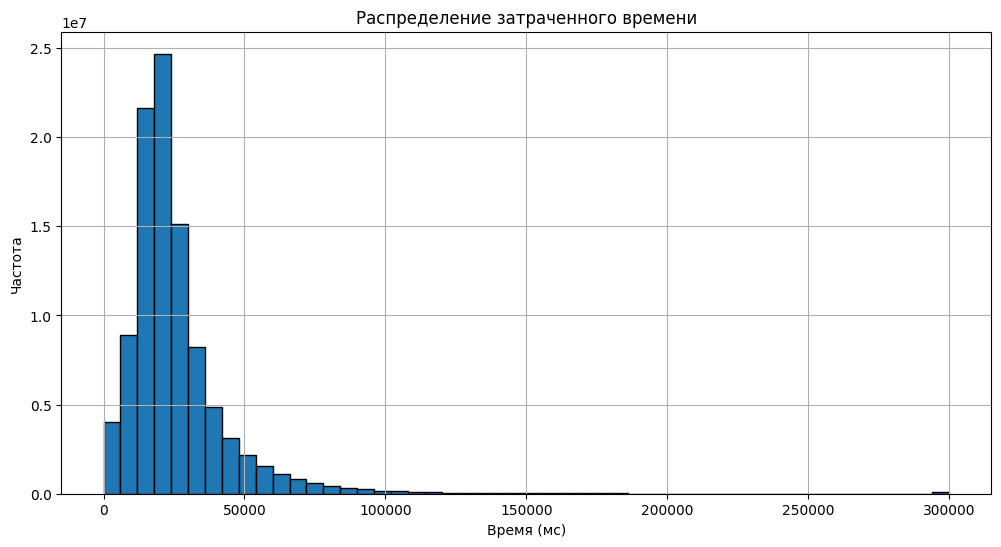

In [56]:
# Собираем данные и преобразуем их в pandas DataFrame
df_pandas = df_tarin_full.collect().to_pandas()

# Настраиваем размер графика
plt.figure(figsize=(12, 6))

# Строим гистограмму
df_pandas["prior_question_elapsed_time"].hist(bins=50, edgecolor='black')
plt.title("Распределение затраченного времени")
plt.xlabel("Время (мс)")
plt.ylabel("Частота")
plt.show()


Большинство пользователей тратят менее 50 секунд на вопрос.

Посмотрим на данные вопросов и лекций. Также обратим внимание на типы данных.

In [57]:
print("Типы данных\n", df_questions.collect_schema())
print("Первые 5 записей\n", df_questions.head(5).collect())

Типы данных
 Schema([('question_id', Int64), ('bundle_id', Int64), ('correct_answer', Int64), ('part', Int64), ('tags', String)])
Первые 5 записей
 shape: (5, 5)
┌─────────────┬───────────┬────────────────┬──────┬────────────────┐
│ question_id ┆ bundle_id ┆ correct_answer ┆ part ┆ tags           │
│ ---         ┆ ---       ┆ ---            ┆ ---  ┆ ---            │
│ i64         ┆ i64       ┆ i64            ┆ i64  ┆ str            │
╞═════════════╪═══════════╪════════════════╪══════╪════════════════╡
│ 0           ┆ 0         ┆ 0              ┆ 1    ┆ 51 131 162 38  │
│ 1           ┆ 1         ┆ 1              ┆ 1    ┆ 131 36 81      │
│ 2           ┆ 2         ┆ 0              ┆ 1    ┆ 131 101 162 92 │
│ 3           ┆ 3         ┆ 0              ┆ 1    ┆ 131 149 162 29 │
│ 4           ┆ 4         ┆ 3              ┆ 1    ┆ 131 5 162 38   │
└─────────────┴───────────┴────────────────┴──────┴────────────────┘


In [58]:
print("Типы данных\n", df_lectures.collect_schema())
print("Первые 5 записей\n", df_lectures.head(5).collect())

Типы данных
 Schema([('lecture_id', Int64), ('tag', Int64), ('part', Int64), ('type_of', String)])
Первые 5 записей
 shape: (5, 4)
┌────────────┬─────┬──────┬──────────────────┐
│ lecture_id ┆ tag ┆ part ┆ type_of          │
│ ---        ┆ --- ┆ ---  ┆ ---              │
│ i64        ┆ i64 ┆ i64  ┆ str              │
╞════════════╪═════╪══════╪══════════════════╡
│ 89         ┆ 159 ┆ 5    ┆ concept          │
│ 100        ┆ 70  ┆ 1    ┆ concept          │
│ 185        ┆ 45  ┆ 6    ┆ concept          │
│ 192        ┆ 79  ┆ 5    ┆ solving question │
│ 317        ┆ 156 ┆ 5    ┆ solving question │
└────────────┴─────┴──────┴──────────────────┘


Посмотрим как влияет наличие объяснения на правильность ответов

In [59]:
# Группа с объяснениями
group_with_explanations = df_train_q.filter(pl.col("prior_question_had_explanation") == True)
percent_correct_with_explanations = group_with_explanations.select(
    pl.col("answered_correctly").mean()
).collect().item() * 100

# Группа без объяснений
group_without_explanations = df_train_q.filter(pl.col("prior_question_had_explanation") == False)
percent_correct_without_explanations = group_without_explanations.select(
    pl.col("answered_correctly").mean()
).collect().item() * 100

# Вывод результата
print(f"Процент правильных ответов с полученными объяснениями на предыдущий вопрос: {percent_correct_with_explanations:.2f}%")
print(f"Процент правильных ответов без полученных объяснений на предыдущий вопрос: {percent_correct_without_explanations:.2f}%")


Процент правильных ответов с полученными объяснениями на предыдущий вопрос: 67.32%
Процент правильных ответов без полученных объяснений на предыдущий вопрос: 50.06%


Процент правильных ответов выше, если были получены объяснения на предыдущий вопрос

Теперь проведем анализ зависимости времени на правильность ответов

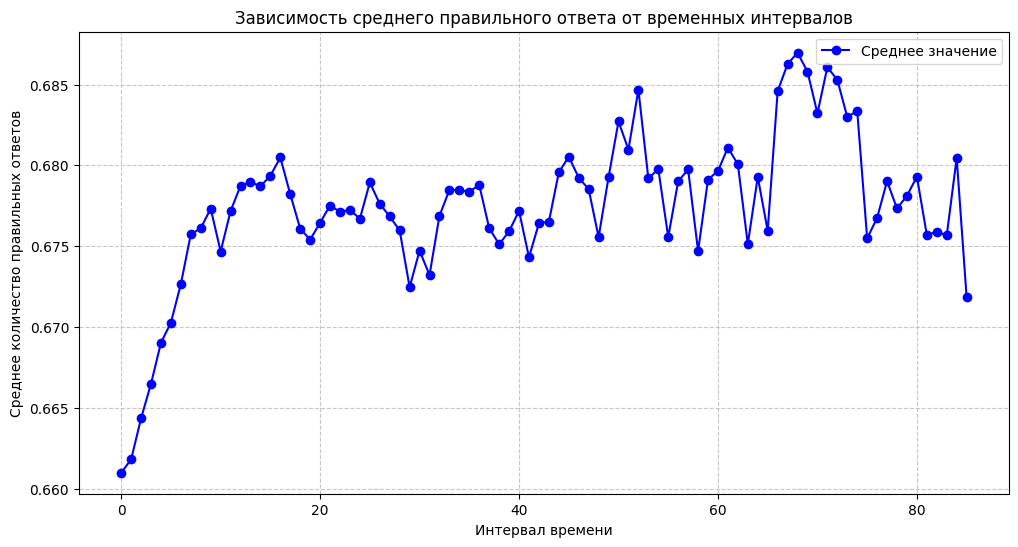

In [60]:
# Убираем выбросы и группируем данные
processed_data = (
    df_train_q
    .filter(
        (pl.col('timestamp') <= pl.col('timestamp').quantile(0.9)) &
        (pl.col('timestamp') >= 250000000)
    )
    .with_columns(
        (pl.col('timestamp') // 270000000).alias('time_interval')
    )
    .group_by('time_interval')
    .agg(
        pl.col('answered_correctly').mean().alias('avg_correct')
    )
    .sort('time_interval')
    .collect()
)

# Преобразуем результат в Pandas для графика
df_plot = processed_data.to_pandas()

# Построение графика с использованием matplotlib
plt.figure(figsize=(12, 6))
plt.plot(df_plot['time_interval'], df_plot['avg_correct'], marker='o', linestyle='-', color='b', label='Среднее значение')
plt.title("Зависимость среднего правильного ответа от временных интервалов")
plt.xlabel("Интервал времени")
plt.ylabel("Среднее количество правильных ответов")
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()


На представленном графике зависимости среднего количества правильных ответов от временных интервалов можно выделить несколько интересных наблюдений:

1. Колебания среднего правильного ответа: График показывает, что среднее количество правильных ответов изменяется с течением времени. Особенно заметно, что в некоторых интервалах времени наблюдаются резкие пики и спады. Это может свидетельствовать о разных уровнях сложности вопросов в различных временных периодах.

2. Общее поведение: Вначале графика наблюдается рост среднего числа правильных ответов, что может указывать на более высокую точность ответов в начале (возможно, вопросы проще или пользователи лучше подготовлены).

3. Нестабильность: Периоды, когда график демонстрирует резкие колебания, могут указывать на разные факторы:

- Это может быть связано с изменениями сложности вопросов или с тем, как пользователи воспринимают их.

- Также такие колебания могут быть результатом ошибок или недостаточной обработки данных.

4. Выводы о времени и правильности ответов: График может подразумевать, что в определенные интервалы времени (например, в среднем времени около 20–30 и 50–60) пользователи либо быстрее адаптируются к задаче, либо более уверенно отвечают. Это может быть связано с улучшением понимания задач с течением времени.


Далее найдем связь с темами вопросов. Для этого объединим данные датафрейм с датафреймом, содержащим вопросы.

In [61]:
df_train_questions = df_train_q.join(df_questions, left_on="content_id", right_on="question_id", how="left")
df_train_questions_tag = df_train_questions.with_columns(pl.col('tags').str.split(" "))

# Выводим первые 5 строк
print(df_train_questions.head(5).collect())

shape: (5, 14)
┌────────┬───────────┬─────────┬────────────┬───┬───────────┬────────────────┬──────┬────────────┐
│ row_id ┆ timestamp ┆ user_id ┆ content_id ┆ … ┆ bundle_id ┆ correct_answer ┆ part ┆ tags       │
│ ---    ┆ ---       ┆ ---     ┆ ---        ┆   ┆ ---       ┆ ---            ┆ ---  ┆ ---        │
│ i64    ┆ i64       ┆ i64     ┆ i64        ┆   ┆ i64       ┆ i64            ┆ i64  ┆ str        │
╞════════╪═══════════╪═════════╪════════════╪═══╪═══════════╪════════════════╪══════╪════════════╡
│ 0      ┆ 0         ┆ 115     ┆ 5692       ┆ … ┆ 5692      ┆ 3              ┆ 5    ┆ 151        │
│ 1      ┆ 56943     ┆ 115     ┆ 5716       ┆ … ┆ 5716      ┆ 2              ┆ 5    ┆ 168        │
│ 2      ┆ 118363    ┆ 115     ┆ 128        ┆ … ┆ 128       ┆ 0              ┆ 1    ┆ 131 149 92 │
│ 3      ┆ 131167    ┆ 115     ┆ 7860       ┆ … ┆ 7860      ┆ 0              ┆ 1    ┆ 131 104 81 │
│ 4      ┆ 137965    ┆ 115     ┆ 7922       ┆ … ┆ 7922      ┆ 1              ┆ 1    ┆ 131 149 

Посмотрим как связаны теги со средним количеством правильных ответов

In [62]:
# Разбиваем столбец tags на отдельные строки
df_train_questions_tag = df_train_questions_tag.select(pl.col('answered_correctly'), pl.col('tags')).explode('tags').group_by(pl.col('tags').alias('tag')).agg(pl.col('answered_correctly').mean().alias('avg_correct')).drop_nulls().sort('avg_correct')
print(df_train_questions_tag.collect(streaming=True))

shape: (188, 2)
┌─────┬─────────────┐
│ tag ┆ avg_correct │
│ --- ┆ ---         │
│ str ┆ f64         │
╞═════╪═════════════╡
│ 24  ┆ 0.385725    │
│ 23  ┆ 0.438487    │
│ 19  ┆ 0.439938    │
│ 151 ┆ 0.493155    │
│ 167 ┆ 0.500432    │
│ …   ┆ …           │
│ 40  ┆ 0.813804    │
│ 149 ┆ 0.848015    │
│ 130 ┆ 0.853152    │
│ 187 ┆ 0.85602     │
│ 68  ┆ 0.863945    │
└─────┴─────────────┘


**Анализ данных по среднему количеству правильных ответов по тегам:**

1. **Теги с низким средним количеством правильных ответов**:
   - Примеры: теги `24` (38.6%), `23` (43.8%), и `19` (43.9%).
   - Такие низкие значения могут свидетельствовать о:
     - Сложности заданий, относящихся к этим темам.
     - Недостаточной подготовке пользователей по данным темам.
     - Возможных ошибках в вопросах или неинтуитивной формулировке.

2. **Теги с высоким средним количеством правильных ответов**:
   - Примеры: теги `68` (86.4%), `187` (85.6%), и `130` (85.3%).
   - Высокие значения говорят о:
     - Простоте заданий, относящихся к этим темам.
     - Хорошей подготовке пользователей по данным темам.
     - Возможности, что вопросы слишком простые и не выявляют реальные знания.

3. **Общий тренд**:
   - Среднее количество правильных ответов распределено по всему диапазону (от ~38% до ~86%).
   - Это может указывать на разнообразие сложности вопросов и распределение знаний пользователей по темам.

 **Можно дать некоторые рекомендации**:
   - **Теги с низкими результатами**:
     - Рассмотреть возможность упрощения вопросов или добавления обучающих материалов.
     - Провести анализ метаданных, чтобы понять, почему пользователи чаще ошибаются.
   - **Теги с высокими результатами**:
     - Оценить, не слишком ли они просты. Возможно, их следует сделать более сложными для увеличения дифференциации между пользователями.


Посмотрим как связаны разделы со средним количеством правильных ответов

In [63]:
df_train_questions_part = df_train_questions.select(pl.col('answered_correctly'), pl.col('part')).group_by(pl.col('part').alias('part')).agg(pl.col('answered_correctly').mean().alias('avg_correct')).drop_nulls().sort('avg_correct')
print(df_train_questions_part.collect(streaming=True))

shape: (7, 2)
┌──────┬─────────────┐
│ part ┆ avg_correct │
│ ---  ┆ ---         │
│ i64  ┆ f64         │
╞══════╪═════════════╡
│ 5    ┆ 0.610088    │
│ 4    ┆ 0.630998    │
│ 7    ┆ 0.659601    │
│ 6    ┆ 0.669388    │
│ 3    ┆ 0.701456    │
│ 2    ┆ 0.708694    │
│ 1    ┆ 0.745032    │
└──────┴─────────────┘


**Анализ средних правильных ответов по разделам (part):**

1. **Распределение средних правильных ответов**:
   - Средний уровень правильных ответов варьируется от **61%** (part 5) до **74.5%** (part 1).
   - Различия между разделами указывают на разные уровни сложности вопросов или разный уровень подготовки пользователей по разделам.

2. **Разделы с самым низким средним уровнем правильных ответов**:
   - **part 5 (61.0%)** и **part 4 (63.1%)**:
     - Эти разделы могли содержать более сложные вопросы или вопросы, которые пользователи воспринимают как менее знакомые.
     - Также возможна специфика тематики или формата вопросов, затрудняющая ответы.

3. **Разделы с самым высоким средним уровнем правильных ответов**:
   - **part 1 (74.5%)** и **part 2 (70.9%)**:
     - Эти разделы, вероятно, содержат более простые вопросы или те, которые пользователи лучше понимают.
     - Возможно, вопросы здесь связаны с базовыми знаниями, хорошо знакомыми большинству участников.

4. **Общий тренд**:
   - Уровень правильных ответов уменьшается с первом разделе (самый высокий показатель) к пятой (самый низкий).
   - Это может быть связано с постепенным увеличением сложности или с утомляемостью пользователей по мере прохождения вопросов.

 **Можно дать такие рекомендации**:
   - **Для разделов с низким средним уровнем**:
     - Провести дополнительный анализ тем, формулировок вопросов и времени, требуемого на ответы.
     - Упростить вопросы или снабдить пользователей обучающими материалами.
   - **Для разделов с высоким средним уровнем**:
     - Проверить, не слишком ли они просты. Возможно, стоит добавить больше вопросов с умеренной сложностью.
  



shape: (7, 2)
┌──────┬──────────────────┐
│ part ┆ avg_elapsed_time │
│ ---  ┆ ---              │
│ i64  ┆ f64              │
╞══════╪══════════════════╡
│ 2    ┆ 18715.771424     │
│ 1    ┆ 22671.48607      │
│ 3    ┆ 23619.335747     │
│ 4    ┆ 23758.835498     │
│ 5    ┆ 25233.249525     │
│ 6    ┆ 32413.610744     │
│ 7    ┆ 47447.495993     │
└──────┴──────────────────┘


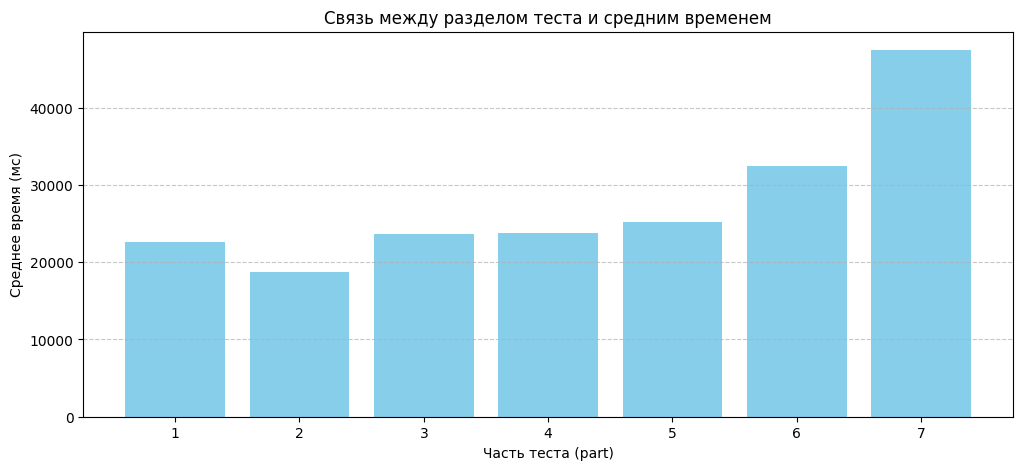

In [67]:
# Выбираем необходимые столбцы и группируем по part
df_train_questions_part_time = (
    df_train_questions
    .select(pl.col('prior_question_elapsed_time'), pl.col('part'))
    .group_by(pl.col('part').alias('part'))
    .agg(
        pl.col('prior_question_elapsed_time').mean().alias('avg_elapsed_time')  # Среднее время ответа
    )
    .drop_nulls()  # Убираем строки с отсутствующими значениями
    .sort('avg_elapsed_time')  # Сортируем по среднему времени ответа
)

# Выводим результаты
print(df_train_questions_part_time.collect(streaming=True))

# Для визуализации в Matplotlib
import matplotlib.pyplot as plt

# Конвертируем результат в Pandas для построения графика
df_part_time_pd = df_train_questions_part_time.collect().to_pandas()

# Построение столбчатой диаграммы
plt.figure(figsize=(12, 5))
plt.bar(df_part_time_pd['part'], df_part_time_pd['avg_elapsed_time'], color='skyblue')
plt.title('Связь между разделом теста и средним временем')
plt.xlabel('Часть теста (part)')
plt.ylabel('Среднее время (мс)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

На основе анализа данных можно сделать следующие выводы:  

1. **Раздел 2 оказался самым малозатратным по времени.**  
   Участники теста тратили на него меньше всего времени, что может указывать на его относительную простоту или на хорошо знакомый материал.  

2. **Разделы 1, 3, 4 и 5 характеризуются примерно одинаковым средним временем выполнения.**  
   Это свидетельствует о сопоставимой сложности заданий в этих разделах или их аналогичной структуре.  

3. **Раздел 7 требует наибольшего количества времени.**  
   Участники тратили на него значительно больше времени, чем на другие разделы. Это может говорить о повышенной сложности заданий, необходимости более тщательного анализа вопросов или незнакомости с материалом.  

В целом, различия во времени, затраченном на выполнение разделов, помогают понять, какие части теста вызывают наибольшие затруднения, а какие являются относительно простыми.